In [1]:
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pymc3 as pm
from hmmlearn import vhmm
from scipy.stats import pointbiserialr
from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    roc_curve, 
)
from side_info_decoding.bmm_hmm import (
    BMM_HMM, HMM, Oracle_BMM_HMM, BetaProcess, Constrained_BMM_HMM, posterior_inference
)
from side_info_decoding.viz import plot_multi_session_hmm_results, plot_bmm_hmm_results

from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

seed = 666

fit oracle model

In [149]:
brain_region = "ca1"

dir_path = Path("/home/yizi/density_decoding/saved_results")

pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    "523f8301-4f56-4faf-ab33-a9ff11331118",
    "0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a",
    "143dd7cf-6a47-47a1-906d-927ad7fe9117",
    "16799c7a-e395-435d-a4c4-a678007e1550",
    "1e176f17-d00f-49bb-87ff-26d237b525f1",
    "27bac116-ea57-4512-ad35-714a62d259cd",
    "31f3e083-a324-4b88-b0a4-7788ec37b191",
    "6fc4d73c-2071-43ec-a756-c6c6d8322c8b",
    "7d999a68-0215-4e45-8e6c-879c6ca2b771",
    "8b7c808f-763b-44c8-b273-63c6afbc6aae",
    "9117969a-3f0d-478b-ad75-98263e3bfacf",
    "ad714133-1e03-4d3a-8427-33fc483daf1a"
]

ys, ds = [], []
for _, pid in enumerate(pids):

    y, d, trial_idx = [], [], []
    for i in range(5):
        y.append(
            np.load(
                dir_path/pid/"choice"/"all"/"y_obs"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["density_based"]
        )
        d.append(
            np.load(
                dir_path/pid/"choice"/brain_region/"y_prob"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["density_based"]
        )
        trial_idx.append(
            np.load(
                dir_path/pid/"choice"/"all"/"trial_idx"/f"fold_{i+1}.npy", allow_pickle=True
            )
        )
    trial_idx = np.concatenate(trial_idx)
    y = np.concatenate(y)[np.argsort(trial_idx)]
    d = np.concatenate(d)[np.argsort(trial_idx),1]
    ys.append(y.reshape(-1,1))
    ds.append(d.reshape(-1,1))
ys = np.array(ys)
ds = np.array(ds)

/tmp/ipykernel_6599/1497462015.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ys = np.array(ys)
/tmp/ipykernel_6599/1497462015.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ds = np.array(ds)


In [150]:
pid = pids[3]
print(pid)
print(brain_region)
d = ds[3].squeeze()
y = ys[3].squeeze()

save_path, save_metrics = {}, {}
out_path = Path("/home/yizi/side_info_decoding/saved_results")
for res in ["oracle_bmm_hmm_metrics", "oracle_bmm_hmm_figures"]:
    save_path.update({res: out_path/res/pid})
    os.makedirs(save_path[res], exist_ok=True)

523f8301-4f56-4faf-ab33-a9ff11331118
ca1


In [151]:
# learn hmm params from observed choices

init_pi = {0: np.log(.4), 1:np.log(.5), 2: np.log(.1)}
init_a = {
        0: {0: np.log(.6), 1: np.log(.3), 2: np.log(.1)},
        1: {0: np.log(.3), 1: np.log(.6), 2: np.log(.1)},
        2: {0: np.log(.1), 1: np.log(.3), 2: np.log(.6)} }
init_b = {
        0: {0: np.log(.6), 1: np.log(.4)},
        1: {0: np.log(.4), 1: np.log(.6)},
        2: {0: np.log(.6), 1: np.log(.4)}
         }
p = [init_pi, init_a, init_b]

hmm = HMM(p)
hmm.update(y, 1e-5)

oracle_states = np.array([np.array(list(state.values())) for state in hmm.forward(y)])
oracle_states = np.exp(oracle_states)
oracle_states = oracle_states / oracle_states.sum(1)[:,None]

a_hat = hmm.forward_backward(y)[1]
b_hat = hmm.forward_backward(y)[2]
oracle_A = np.exp(
    [[a_hat[0][0], a_hat[0][1], a_hat[0][2]], 
     [a_hat[1][0], a_hat[1][1], a_hat[1][2]],
     [a_hat[2][0], a_hat[2][1], a_hat[2][2]]]
)
oracle_B = np.exp(
    [[b_hat[0][0], b_hat[0][1]], 
     [b_hat[1][0], b_hat[1][1]],
     [b_hat[2][0], b_hat[2][1]]]
)

In [152]:
# learn bmm params from observed choices

with pm.Model() as beta_model:
    alpha = pm.Exponential("a", 1, shape = 2)
    beta = pm.Exponential("b", 1, shape = 2)
    dk = BetaProcess('d', y, alpha, beta, observed=d)
    step = pm.NUTS()     
    trace = pm.sample(draws=1000, step=step, chains=2, progressbar=True)  
    beta_ppc = pm.sample_posterior_predictive(
        trace, var_names=["a", "b", "d"], random_seed=seed
    )
a0, a1 = beta_ppc["a"].mean(0)
b0, b1 = beta_ppc["b"].mean(0)
print(a0, b0, a1, b1)

/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


0.491810434485297 0.6460282735887669 0.6680153028001674 0.38807906007024306


In [153]:
A = oracle_A
B = oracle_B

In [154]:
# initialize bmm-hmm

states = [0, 1, 2]
init_pi = {0:hmm.pi[0], 1:hmm.pi[1], 2:hmm.pi[2]}
init_a = {
    0: {0: np.log(A[0][0]), 1: np.log(A[0][1]), 2: np.log(A[0][2])},
    1: {0: np.log(A[1][0]), 1: np.log(A[1][1]), 2: np.log(A[1][2])},
    2: {0: np.log(A[2][0]), 1: np.log(A[2][1]), 2: np.log(A[2][2])} 
}
init_phi = {
    0: {0: np.log(B[0][0]), 1: np.log(B[0][1])},
    1: {0: np.log(B[1][0]), 1: np.log(B[1][1])},
    2: {0: np.log(B[2][0]), 1: np.log(B[2][1])}
}
init_beta_a = [a1, a0]
init_beta_b = [b1, b0]

# fit bmm-hmm

bmm_hmm = Oracle_BMM_HMM(d, init_pi, init_a, init_phi, init_beta_a, init_beta_b, tol=1e-1)
bmm_hmm.update(d)

In [155]:
a_hat = bmm_hmm.a
phi_hat = bmm_hmm.phi
beta_a_hat = bmm_hmm.beta_a
beta_b_hat = bmm_hmm.beta_b

A = np.exp(
    [[a_hat[0][0], a_hat[0][1], a_hat[0][2]], 
     [a_hat[1][0], a_hat[1][1], a_hat[1][2]],
     [a_hat[2][0], a_hat[2][1], a_hat[2][2]]]
)

B = np.exp(
    [[phi_hat[0][0], phi_hat[0][1]], 
     [phi_hat[1][0], phi_hat[1][1]],
     [phi_hat[2][0], phi_hat[2][1]]]
)

In [156]:
states = np.array([np.array(list(state.values())) for state in bmm_hmm.forward(d)])
states = np.exp(states)
states = states / states.sum(1)[:,None]
states[np.isnan(states)] = np.tile(np.nanmean(states, 0), int(len(states[np.isnan(states)])/states.shape[1]))
oracle_preds, oracle_probs = posterior_inference(bmm_hmm, d)

In [157]:
print(roc_auc_score(y, oracle_preds))

0.7158923878669102


fit single-session model

In [139]:
brain_region = "ca1"

dir_path = Path("/home/yizi/density_decoding/saved_results")

pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    "523f8301-4f56-4faf-ab33-a9ff11331118",
    "0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a",
    "143dd7cf-6a47-47a1-906d-927ad7fe9117",
    "16799c7a-e395-435d-a4c4-a678007e1550",
    "1e176f17-d00f-49bb-87ff-26d237b525f1",
    "27bac116-ea57-4512-ad35-714a62d259cd",
    "31f3e083-a324-4b88-b0a4-7788ec37b191",
    "6fc4d73c-2071-43ec-a756-c6c6d8322c8b",
    "7d999a68-0215-4e45-8e6c-879c6ca2b771",
    "8b7c808f-763b-44c8-b273-63c6afbc6aae",
    "9117969a-3f0d-478b-ad75-98263e3bfacf",
    "ad714133-1e03-4d3a-8427-33fc483daf1a"
]

ys, ds = [], []
for _, pid in enumerate(pids):

    y, d, trial_idx = [], [], []
    for i in range(5):
        y.append(
            np.load(
                dir_path/pid/"choice"/"all"/"y_obs"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["density_based"]
        )
        d.append(
            np.load(
                dir_path/pid/"choice"/brain_region/"y_prob"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["density_based"]
        )
        trial_idx.append(
            np.load(
                dir_path/pid/"choice"/"all"/"trial_idx"/f"fold_{i+1}.npy", allow_pickle=True
            )
        )
    trial_idx = np.concatenate(trial_idx)
    y = np.concatenate(y)[np.argsort(trial_idx)]
    d = np.concatenate(d)[np.argsort(trial_idx),1]
    ys.append(y.reshape(-1,1))
    ds.append(d.reshape(-1,1))
ys = np.array(ys)
ds = np.array(ds)

/tmp/ipykernel_6599/1497462015.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ys = np.array(ys)
/tmp/ipykernel_6599/1497462015.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ds = np.array(ds)


In [140]:
pid = pids[3]
print(pid)
print(brain_region)
d = ds[3].squeeze()
y = ys[3].squeeze()

save_path, save_metrics = {}, {}
out_path = Path("/home/yizi/side_info_decoding/saved_results")
for res in ["vanilla_bmm_hmm_metrics", "vanilla_bmm_hmm_figures"]:
    save_path.update({res: out_path/res/pid})
    os.makedirs(save_path[res], exist_ok=True)

523f8301-4f56-4faf-ab33-a9ff11331118
ca1


In [141]:
# initialize bmm-hmm

states = [0, 1, 2]
init_pi = {0: np.log(0.2), 1:np.log(0.4), 2: np.log(0.4)}
init_a = {
        0: {0: np.log(.9), 1: np.log(.05), 2: np.log(.05)},
        1: {0: np.log(.05), 1: np.log(.9), 2: np.log(.05)},
        2: {0: np.log(.05), 1: np.log(.05), 2: np.log(.9)} }
init_phi = {
        0: {0: np.log(.6), 1: np.log(.4)},
        1: {0: np.log(.9), 1: np.log(.1)},
        2: {0: np.log(.1), 1: np.log(.9)}
         }
init_beta_a = [3, 1]
init_beta_b = [1, 3]

In [142]:
# fit bmm-hmm

bmm_hmm = BMM_HMM(d, init_pi, init_a, init_phi, init_beta_a, init_beta_b, tol=1e-1)
bmm_hmm.update(d)

BMM Convergence Achieved: True
log-likelihood: 106.47082443468457
BMM Convergence Achieved: True
log-likelihood: 107.90832434122814
BMM Convergence Achieved: True
log-likelihood: 108.9095877599366
BMM Convergence Achieved: True
log-likelihood: 109.4830974200909
BMM Convergence Achieved: True
log-likelihood: 109.72937252272926
BMM Convergence Achieved: True
log-likelihood: 109.93156730925932
BMM Convergence Achieved: True
log-likelihood: 109.92130019890108


In [143]:
a_hat = bmm_hmm.a
phi_hat = bmm_hmm.phi
beta_a_hat = bmm_hmm.beta_a
beta_b_hat = bmm_hmm.beta_b

# inference

single_A = np.exp(
    [[a_hat[0][0], a_hat[0][1], a_hat[0][2]], 
     [a_hat[1][0], a_hat[1][1], a_hat[1][2]],
     [a_hat[2][0], a_hat[2][1], a_hat[2][2]]]
)

single_B = np.exp(
    [[phi_hat[0][0], phi_hat[0][1]], 
     [phi_hat[1][0], phi_hat[1][1]],
     [phi_hat[2][0], phi_hat[2][1]]]
)

In [144]:
states = np.array([np.array(list(state.values())) for state in bmm_hmm.forward(d)])
states = np.exp(states)
states = states / states.sum(1)[:,None]
states[np.isnan(states)] = np.tile(np.nanmean(states, 0), int(len(states[np.isnan(states)])/states.shape[1]))
single_preds, single_probs = posterior_inference(bmm_hmm, d)

In [145]:
print(roc_auc_score(y, single_preds))

0.6681884993986904


fit multi-session model

In [129]:
brain_region = "ca1"

dir_path = Path("/home/yizi/density_decoding/saved_results")

pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    "523f8301-4f56-4faf-ab33-a9ff11331118",
    "0b8ea3ec-e75b-41a1-9442-64f5fbc11a5a",
    "143dd7cf-6a47-47a1-906d-927ad7fe9117",
    "16799c7a-e395-435d-a4c4-a678007e1550",
    "1e176f17-d00f-49bb-87ff-26d237b525f1",
    "27bac116-ea57-4512-ad35-714a62d259cd",
    "31f3e083-a324-4b88-b0a4-7788ec37b191",
    "6fc4d73c-2071-43ec-a756-c6c6d8322c8b",
    "7d999a68-0215-4e45-8e6c-879c6ca2b771",
    "8b7c808f-763b-44c8-b273-63c6afbc6aae",
    "9117969a-3f0d-478b-ad75-98263e3bfacf",
    "ad714133-1e03-4d3a-8427-33fc483daf1a"
]

ys, ds = [], []
for _, pid in enumerate(pids):

    y, d, trial_idx = [], [], []
    for i in range(5):
        y.append(
            np.load(
                dir_path/pid/"choice"/"all"/"y_obs"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["density_based"]
        )
        d.append(
            np.load(
                dir_path/pid/"choice"/brain_region/"y_prob"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["density_based"]
        )
        trial_idx.append(
            np.load(
                dir_path/pid/"choice"/"all"/"trial_idx"/f"fold_{i+1}.npy", allow_pickle=True
            )
        )
    trial_idx = np.concatenate(trial_idx)
    y = np.concatenate(y)[np.argsort(trial_idx)]
    d = np.concatenate(d)[np.argsort(trial_idx),1]
    ys.append(y.reshape(-1,1))
    ds.append(d.reshape(-1,1))
ys = np.array(ys)
ds = np.array(ds)

/tmp/ipykernel_6599/1497462015.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ys = np.array(ys)
/tmp/ipykernel_6599/1497462015.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ds = np.array(ds)


In [130]:
# prepare training sessions and test session

test_pid_idx = 3
pid = pids[test_pid_idx]
print(pid)
print(brain_region)
d = ds[test_pid_idx].squeeze()
y = ys[test_pid_idx].squeeze()

save_path, save_metrics = {}, {}
out_path = Path("/home/yizi/side_info_decoding/saved_results")
for res in ["constrained_bmm_hmm_metrics", "constrained_bmm_hmm_figures"]:
    save_path.update({res: out_path/res/pid})
    os.makedirs(save_path[res], exist_ok=True)
    
train_pid_idxs = np.delete(np.arange(len(pids)), test_pid_idx)
train_ys, test_ys = ys[train_pid_idxs], ys[test_pid_idx]
train_ds, test_ds = ds[train_pid_idxs], ds[test_pid_idx]

aligned_train_ys = np.concatenate(train_ys)
lengths = [len(train_ys[idx]) for idx in range(len(train_ys))]

523f8301-4f56-4faf-ab33-a9ff11331118
ca1


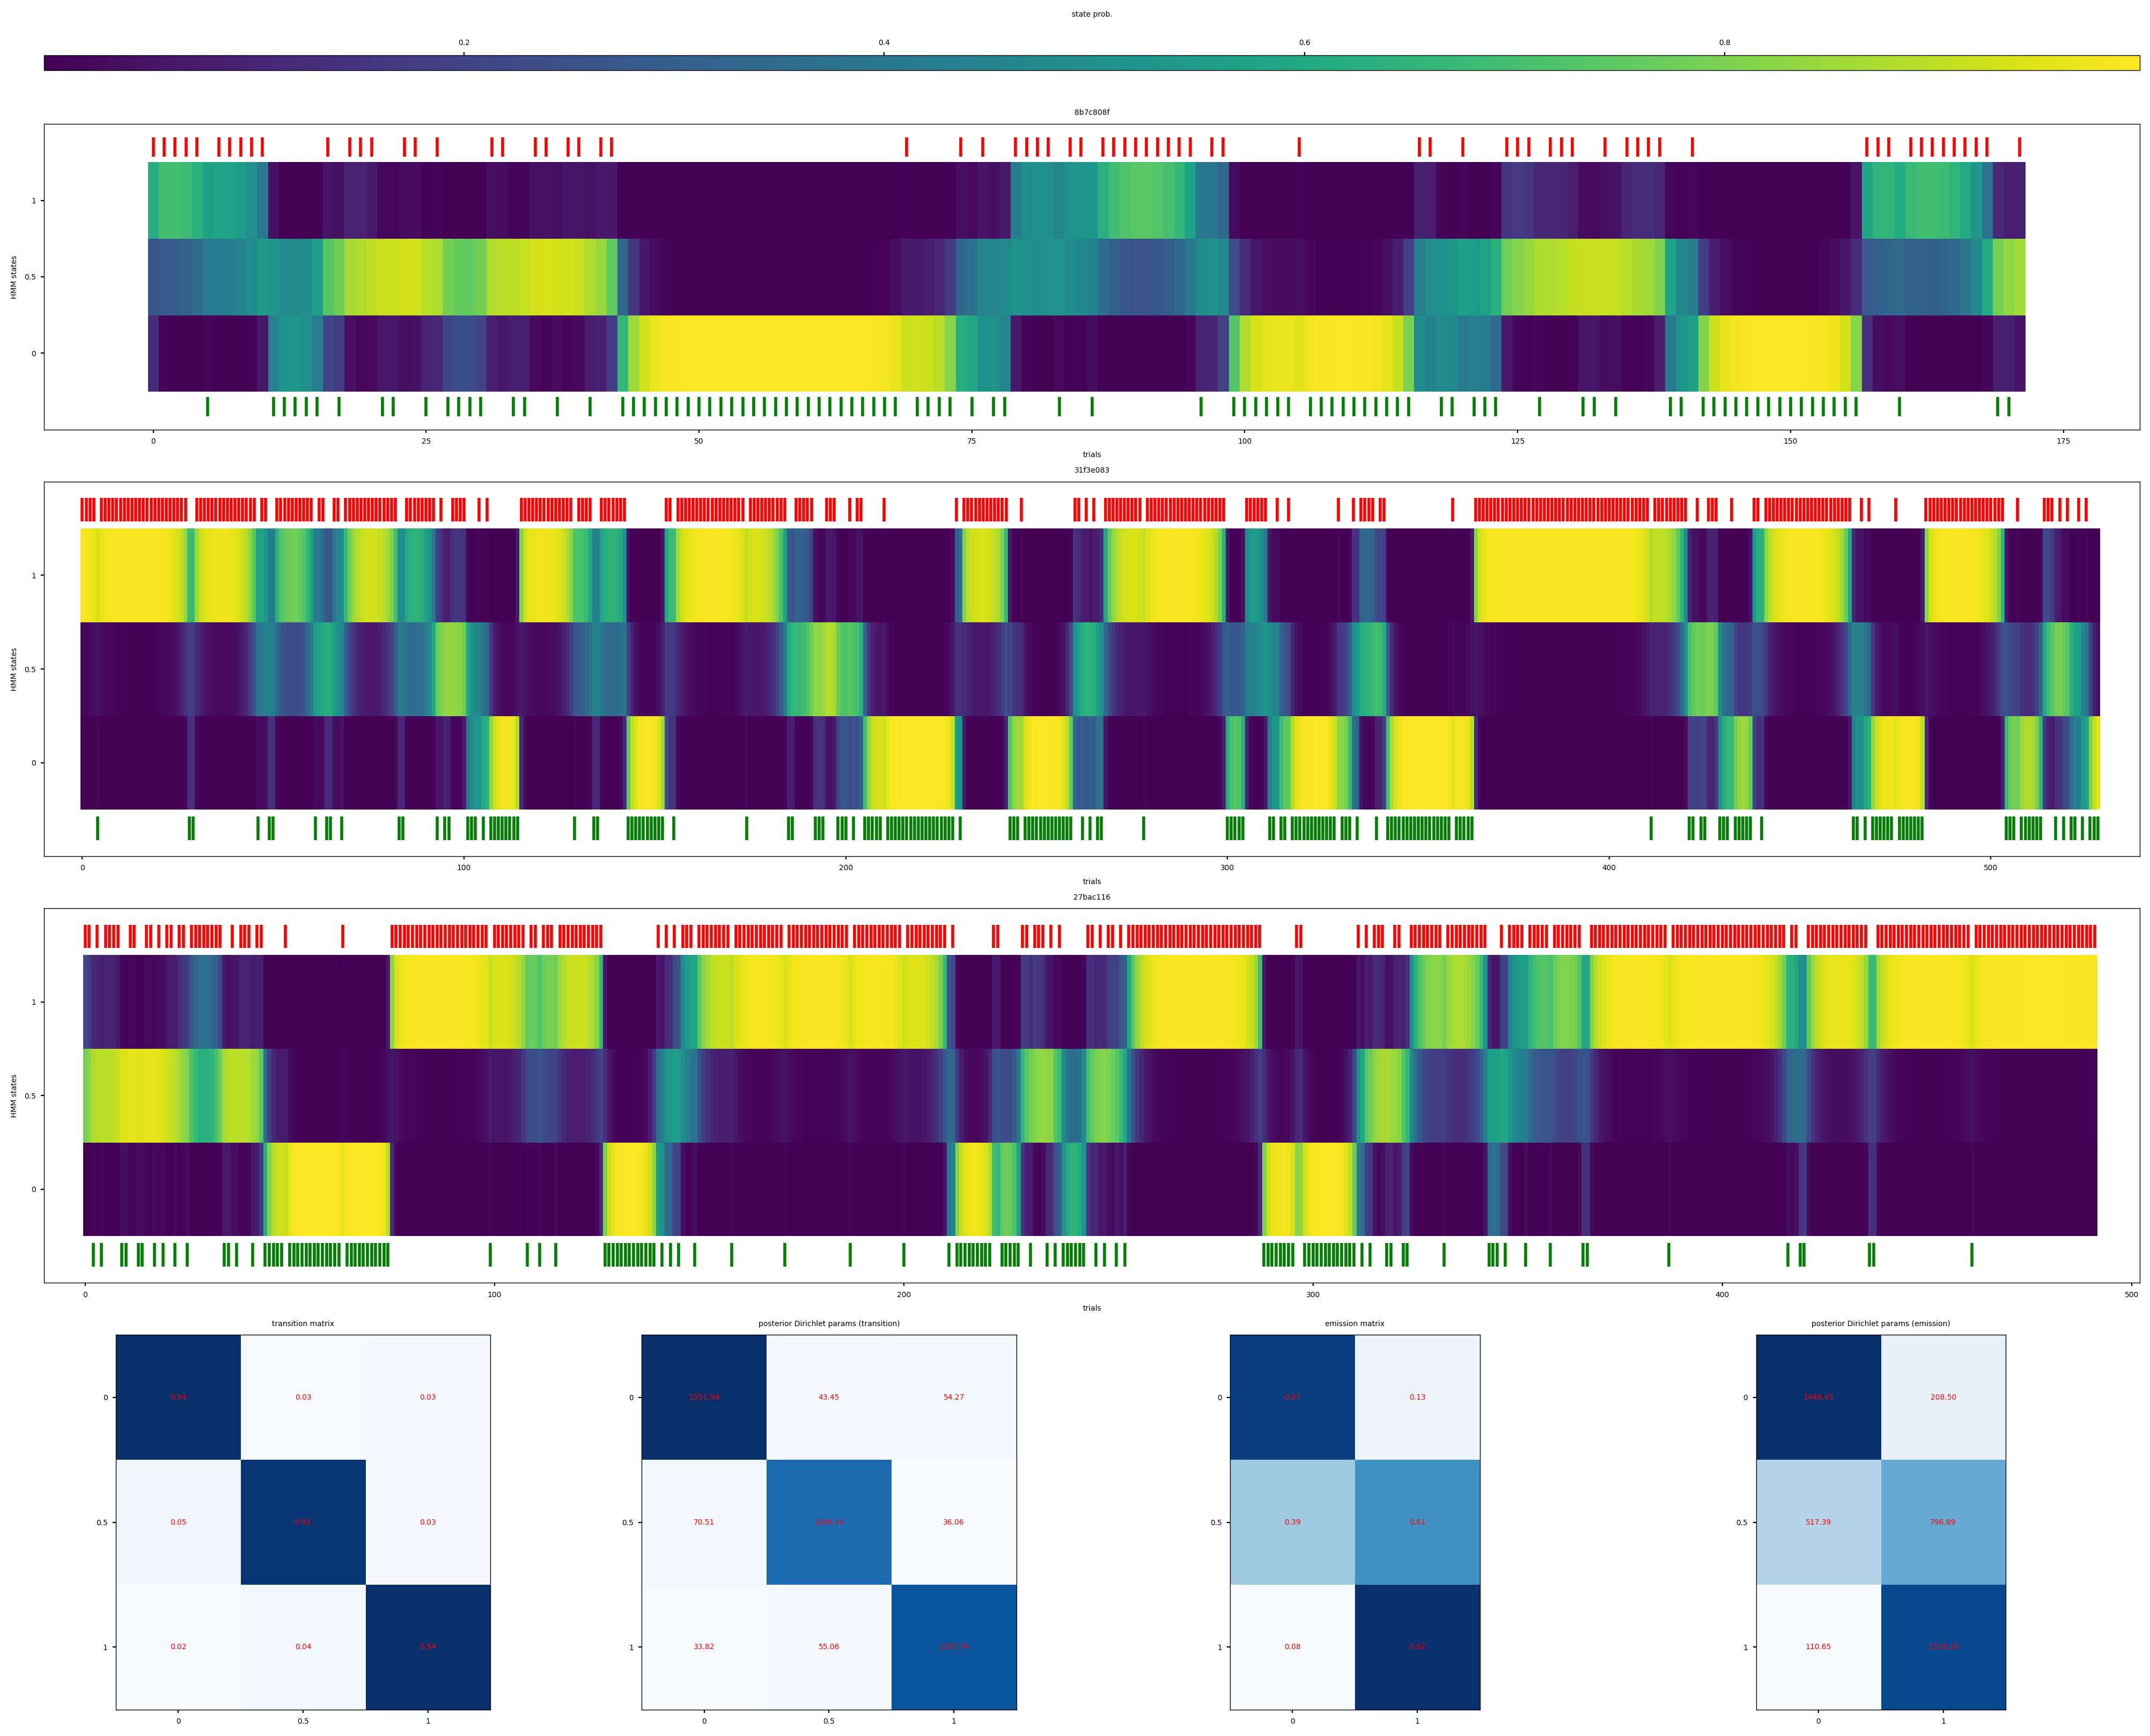

In [132]:
multi_sess_hmm = vhmm.VariationalCategoricalHMM(n_components=3)
multi_sess_hmm.fit(aligned_train_ys, lengths)

aligned_train_states = multi_sess_hmm.predict_proba(aligned_train_ys)
multi_sess_trial_idxs = np.cumsum([0] + lengths)

train_states = [
    aligned_train_states[multi_sess_trial_idxs[i-1]:multi_sess_trial_idxs[i]] for i in range(1, len(multi_sess_trial_idxs))
]

a_constraint = multi_sess_hmm.transmat_
b_constraint = multi_sess_hmm.emissionprob_
pi_posterior = multi_sess_hmm.startprob_posterior_
a_posterior = multi_sess_hmm.transmat_posterior_
b_posterior = multi_sess_hmm.emissionprob_posterior_

# manually check quality of vhmm fit
plot_multi_session_hmm_results(
    states=train_states,
    choices=train_ys,
    pids=np.array(pids)[train_pid_idxs],
    params=(a_constraint, b_constraint, a_posterior, b_posterior)
)

In [133]:
# fit bmm 

train_ds_flat = np.vstack(train_ds).squeeze()
train_ys_flat = np.vstack(train_ys).squeeze()

with pm.Model() as beta_model:
    eta = pm.Gamma("eta", alpha = 5, beta = 1, shape = 2)
    nu = pm.Gamma("nu", alpha = 1, beta = 5, shape = 2)
    # pymc uses rate lambda but scipy uses scale=1/lambda
    alpha = pm.Exponential("a", eta, shape = 2)
    beta = pm.Exponential("b", nu, shape = 2)
    dk = BetaProcess('d', train_ys_flat, alpha, beta, observed=train_ds_flat)
    step = pm.NUTS()     
    trace = pm.sample(draws=1000, step=step, chains=2, progressbar=True)  
    beta_ppc = pm.sample_posterior_predictive(
        trace, var_names=["a", "b", "d", "eta", "nu"], random_seed=seed
    )

a0, a1 = beta_ppc["a"].mean(0)
b0, b1 = beta_ppc["b"].mean(0)
a0_prior, a1_prior = beta_ppc["eta"].mean(0)
b0_prior, b1_prior = beta_ppc["nu"].mean(0)
print([a0, b0, a1, b1])
print([a0_prior, b0_prior, a1_prior, b1_prior])

/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, a, nu, eta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 19 seconds.


[0.45775786878661867, 0.6412427985170407, 0.7376262428171941, 0.4043977481276848]
[4.145054388338552, 0.3546643059650212, 3.412319635736175, 0.3706060553870131]


In [134]:
# initialize bmm-hmm

startprob = multi_sess_hmm.startprob_
pi_prior = multi_sess_hmm.startprob_posterior_
a_prior = multi_sess_hmm.transmat_posterior_
phi_prior = multi_sess_hmm.emissionprob_posterior_

states = [0, 1, 2]
init_pi = {0: np.log(startprob[0]), 1:np.log(startprob[1]), 2: np.log(startprob[2])}
init_a = {
        0: {0: np.log(a_constraint[0][0]), 1: np.log(a_constraint[0][1]), 2: np.log(a_constraint[0][2])},
        1: {0: np.log(a_constraint[1][0]), 1: np.log(a_constraint[1][1]), 2: np.log(a_constraint[1][2])},
        2: {0: np.log(a_constraint[2][0]), 1: np.log(a_constraint[2][1]), 2: np.log(a_constraint[2][2])} }
init_phi = {
        0: {0: np.log(b_constraint[0][0]), 1: np.log(b_constraint[0][1])},
        1: {0: np.log(b_constraint[1][0]), 1: np.log(b_constraint[1][1])},
        2: {0: np.log(b_constraint[2][0]), 1: np.log(b_constraint[2][1])}
         }
init_beta_a = [a1, a0]
init_beta_b = [b1, b0]

beta_a_prior = [a1_prior, a0_prior]
beta_b_prior = [b1_prior, b0_prior]

In [135]:
# fit bmm-hmm
bmm_hmm = Constrained_BMM_HMM(
    d, 
    init_pi, 
    init_a, 
    init_phi, 
    init_beta_a, 
    init_beta_b, 
    pi_prior, 
    a_prior, 
    phi_prior,
    beta_a_prior, 
    beta_b_prior,
    tol=1e-1
)
bmm_hmm.update(d)

BMM Convergence Achieved:  True
log-likelihood: 92.97411877326358
BMM Convergence Achieved:  True
log-likelihood: 93.16567690357847
BMM Convergence Achieved:  True
log-likelihood: 93.14021848948515


In [136]:
a_hat = bmm_hmm.a
phi_hat = bmm_hmm.phi
beta_a_hat = bmm_hmm.beta_a
beta_b_hat = bmm_hmm.beta_b

In [137]:
# inference

multi_A = np.exp(
    [[a_hat[0][0], a_hat[0][1], a_hat[0][2]], 
     [a_hat[1][0], a_hat[1][1], a_hat[1][2]],
     [a_hat[2][0], a_hat[2][1], a_hat[2][2]]]
)

multi_B = np.exp(
    [[phi_hat[0][0], phi_hat[0][1]], 
     [phi_hat[1][0], phi_hat[1][1]],
     [phi_hat[2][0], phi_hat[2][1]]]
)

states = np.array([np.array(list(state.values())) for state in bmm_hmm.forward(d)])
states = np.exp(states)
states = states / states.sum(1)[:,None]
states[np.isnan(states)] = np.tile(np.nanmean(states, 0), int(len(states[np.isnan(states)])/states.shape[1]))
multi_preds, multi_probs = posterior_inference(bmm_hmm, d)

In [138]:
print(roc_auc_score(y, multi_probs))

0.7858892699657031


plotting

In [34]:
%matplotlib inline
plt.rc("figure", dpi=200)
SMALL_SIZE = 15
BIGGER_SIZE = 15
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=.5)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=BIGGER_SIZE)
plt.rc('figure', titlesize=1)
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['ytick.minor.size'] = 3

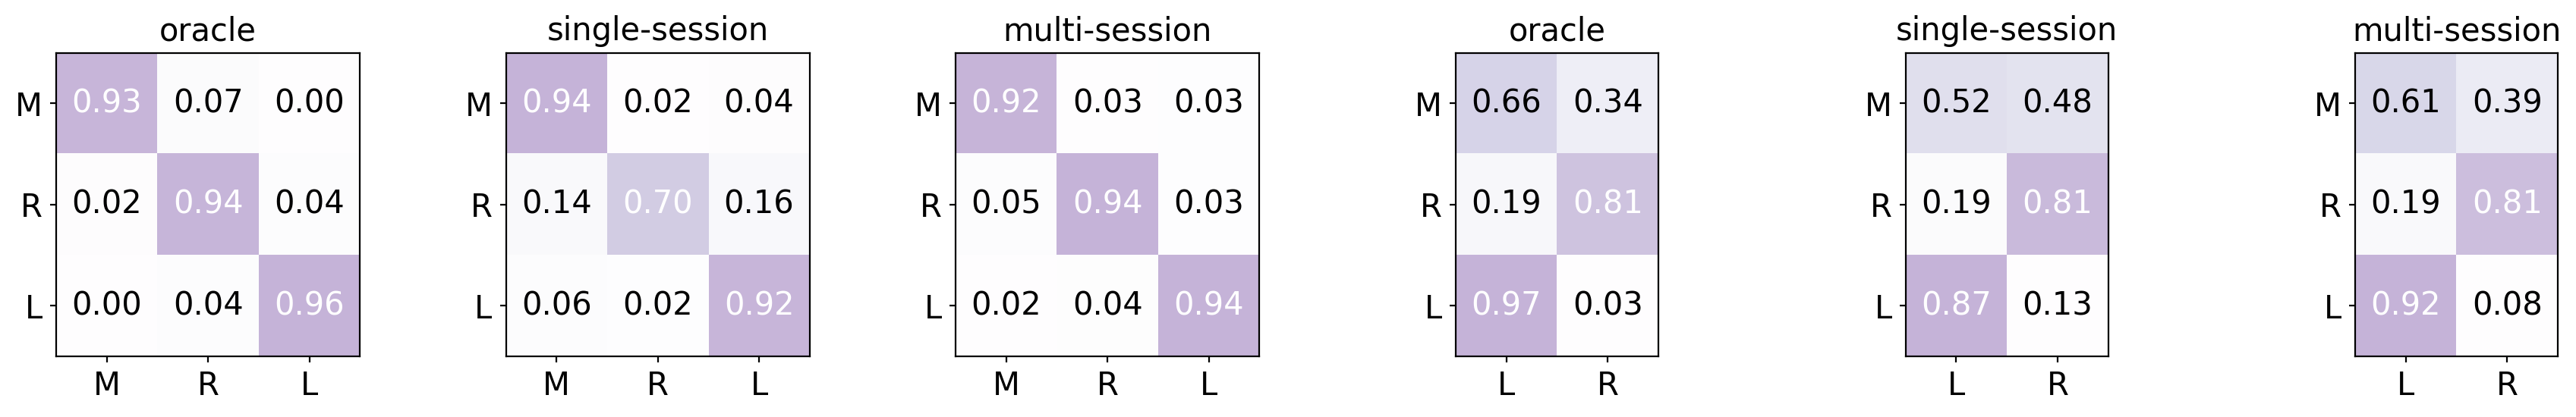

In [50]:
fig, axes = plt.subplots(1, 6, figsize=(18,3))
axes[0].imshow(oracle_A, cmap='Purples', alpha=.3)
axes[0].set_xticks([0,1,2], ["M", "R", "L"])
axes[0].set_yticks([0,1,2], ["M", "R", "L"])
axes[0].set_title("oracle")

for i in range(oracle_A.shape[0]):
    for j in range(oracle_A.shape[1]):
        if i == j:
            axes[0].text(j, i, f'{oracle_A[i, j]:.2f}', ha='center', va='center', color='white')
        else:
            axes[0].text(j, i, f'{oracle_A[i, j]:.2f}', ha='center', va='center', color='k')
            
axes[1].imshow(single_A, cmap='Purples', alpha=.3)
axes[1].set_xticks([0,1,2], ["M", "R", "L"])
axes[1].set_yticks([0,1,2], ["M", "R", "L"])
axes[1].set_title("single-session")

for i in range(single_A.shape[0]):
    for j in range(single_A.shape[1]):
        if i == j:
            axes[1].text(j, i, f'{single_A[i, j]:.2f}', ha='center', va='center', color='white')
        else:
            axes[1].text(j, i, f'{single_A[i, j]:.2f}', ha='center', va='center', color='k')
            
            
axes[2].imshow(multi_A, cmap='Purples', alpha=.3)
axes[2].set_xticks([0,1,2], ["M", "R", "L"])
axes[2].set_yticks([0,1,2], ["M", "R", "L"])
axes[2].set_title("multi-session")

for i in range(multi_A.shape[0]):
    for j in range(multi_A.shape[1]):
        if i == j:
            axes[2].text(j, i, f'{multi_A[i, j]:.2f}', ha='center', va='center', color='white')
        else:
            axes[2].text(j, i, f'{multi_A[i, j]:.2f}', ha='center', va='center', color='k')
            
axes[3].imshow(oracle_B, cmap='Purples', alpha=.3)
axes[3].set_xticks([0,1], ["L", "R"])
axes[3].set_yticks([0,1,2], ["M", "R", "L"])
axes[3].set_title("oracle")

for i in range(oracle_B.shape[0]):
    for j in range(oracle_B.shape[1]):
        if oracle_B[i, j] > 0.7:
            axes[3].text(j, i, f'{oracle_B[i, j]:.2f}', ha='center', va='center', color='white')
        else:
            axes[3].text(j, i, f'{oracle_B[i, j]:.2f}', ha='center', va='center', color='k')
            
axes[4].imshow(single_B, cmap='Purples', alpha=.3)
axes[4].set_xticks([0,1], ["L", "R"])
axes[4].set_yticks([0,1,2], ["M", "R", "L"])
axes[4].set_title("single-session")

for i in range(single_B.shape[0]):
    for j in range(single_B.shape[1]):
        if single_B[i, j] > 0.7:
            axes[4].text(j, i, f'{single_B[i, j]:.2f}', ha='center', va='center', color='white')
        else:
            axes[4].text(j, i, f'{single_B[i, j]:.2f}', ha='center', va='center', color='k')
            
axes[-1].imshow(multi_B, cmap='Purples', alpha=.3)
axes[-1].set_xticks([0,1], ["L", "R"])
axes[-1].set_yticks([0,1,2], ["M", "R", "L"])
axes[-1].set_title("multi-session")

for i in range(multi_B.shape[0]):
    for j in range(multi_B.shape[1]):
        if multi_B[i, j] > 0.7:
            axes[-1].text(j, i, f'{multi_B[i, j]:.2f}', ha='center', va='center', color='white')
        else:
            axes[-1].text(j, i, f'{multi_B[i, j]:.2f}', ha='center', va='center', color='k')
            
plt.tight_layout()
plt.savefig("./plots/bmm_hmm_model_params.png", dpi=400)

In [48]:
single_B = np.array([[0.52, 0.48], [0.19, 0.81], [0.87, 0.13]])
multi_B = np.array([[0.61, 0.39], [0.19, 0.81], [0.92, 0.08]])
multi_A[0,0] = 0.92
multi_A[1,1] = 0.94

In [171]:
%matplotlib inline
plt.rc("figure", dpi=200)
SMALL_SIZE = 5
BIGGER_SIZE = 5
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=.2)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=BIGGER_SIZE)
plt.rc('figure', titlesize=1)
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['ytick.minor.size'] = 2

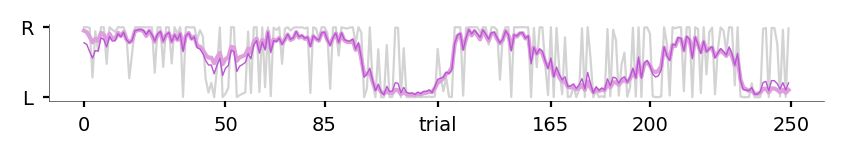

In [172]:
fig, ax = plt.subplots(1,1,figsize=(5,.5))
ax.plot(single_probs[:250], color="lightgray", linewidth=.8, label="single-session")
ax.plot(oracle_probs[:250], color="plum", linewidth=1.5, label="oracle")
ax.plot(multi_probs[:250], color="mediumorchid", linewidth=.5, label="multi-session")
# ax.set_xlim(-5, 205)
ax.set_yticks([0, 1], ["L", "R"], fontsize=7)
ax.set_xticks([0, 50, 85, 125, 165, 200, 250], [0, 50, 85, "trial", 165, 200, 250], fontsize=7)
# ax.legend(bbox_to_anchor=(1, 1.2), ncol=3, frameon=False, fontsize=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.savefig("./plots/bmm_hmm_traces.png", dpi=200)

fit oracle model

In [2]:
dir_path = Path("/home/yizi/density_decoding/saved_results")

pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    "523f8301-4f56-4faf-ab33-a9ff11331118",
    "143dd7cf-6a47-47a1-906d-927ad7fe9117",
    # "1a60a6e1-da99-4d4e-a734-39b1d4544fad",
    # "63517fd4-ece1-49eb-9259-371dc30b1dd6",
    "6fc4d73c-2071-43ec-a756-c6c6d8322c8b",
    "7d999a68-0215-4e45-8e6c-879c6ca2b771",
]

test_pid_idx = 0
test_pid = pids[test_pid_idx]
print(test_pid)

saved_y_obs, saved_y_hat = {}, {}
for brain_region in ["all", "po", "lp", "dg", "ca1", "vis"]:
    
    y_obs, y_hat, k_idx = [], [], []

    for i in range(5):
        y_obs.append(
            np.load(
                dir_path/test_pid/"prior"/brain_region/"y_obs"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["all_ks"]
        )
        y_hat.append(
            np.load(
                dir_path/test_pid/"prior"/brain_region/"y_pred"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["all_ks"]
        )
        k_idx.append(
            np.load(
                dir_path/test_pid/"choice"/brain_region/"trial_idx"/f"fold_{i+1}.npy", allow_pickle=True
            )
        )

    k_idx = np.concatenate(k_idx)
    y_obs = np.concatenate(y_obs)[np.argsort(k_idx)]
    y_hat = np.concatenate(y_hat)[np.argsort(k_idx)]
    
    saved_y_obs.update({brain_region: y_obs})
    saved_y_hat.update({brain_region: y_hat})

dab512bd-a02d-4c1f-8dbc-9155a163efc0


In [3]:
seq_len = len(saved_y_hat[brain_region])

with pm.Model() as vanilla_ssm:
    
    # priors
    rho = pm.Normal("rho", mu=0, sigma=1, shape=1)
    xi = pm.HalfNormal("xi", sigma=1, shape=1)
    
    # low snr
    alpha = pm.Normal("alpha", mu=0.5, sigma=1, shape=1)
    beta = pm.Normal("beta", mu=0, sigma=1, shape=1)
    # high snr
    # alpha = pm.Normal("alpha", mu=0, sigma=1, shape=1)
    # beta = pm.Normal("beta", mu=1, sigma=1, shape=1)
    
    eps = pm.HalfNormal("eps", sigma=1, shape=1)
    
    # dynamic model AR(1)
    x = pm.AR1("state", k=rho, tau_e=1/xi, shape=seq_len)
    
    # observation model (linear-Gaussian)
    y = pm.Normal("obs", 
                  mu=alpha + beta * x, 
                  sigma=eps, 
                  observed=saved_y_obs[brain_region])
    
    trace = pm.sample(1000,
                      target_accept=0.95,
                      tune=1000)  
    
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["obs", "state", "beta", "alpha", "rho", "eps", "xi"], random_seed=seed
    )

/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [state, eps, beta, alpha, xi, rho]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
There were 210 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7824339005048846, but should be close to 0.95. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 129 divergences after tuning. Increase `target_accept` or repar

In [4]:
oracle_rho = ppc["rho"].mean(0)[0]
oracle_theta = ppc["alpha"].mean(0)[0]
oracle_mu = ppc["beta"].mean(0)[0]
oracle_pred = ppc["obs"].mean(0)

fit single-session model

In [5]:
dir_path = Path("/home/yizi/density_decoding/saved_results")

pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    "523f8301-4f56-4faf-ab33-a9ff11331118",
    "143dd7cf-6a47-47a1-906d-927ad7fe9117",
    # "1a60a6e1-da99-4d4e-a734-39b1d4544fad",
    # "63517fd4-ece1-49eb-9259-371dc30b1dd6",
    "6fc4d73c-2071-43ec-a756-c6c6d8322c8b",
    "7d999a68-0215-4e45-8e6c-879c6ca2b771",
]

test_pid_idx = 0
test_pid = pids[test_pid_idx]
print(test_pid)

saved_y_obs, saved_y_hat = {}, {}
for brain_region in ["all", "po", "lp", "dg", "ca1", "vis"]:
    
    y_obs, y_hat, k_idx = [], [], []

    for i in range(5):
        y_obs.append(
            np.load(
                dir_path/test_pid/"prior"/brain_region/"y_obs"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["all_ks"]
        )
        y_hat.append(
            np.load(
                dir_path/test_pid/"prior"/brain_region/"y_pred"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["all_ks"]
        )
        k_idx.append(
            np.load(
                dir_path/test_pid/"choice"/brain_region/"trial_idx"/f"fold_{i+1}.npy", allow_pickle=True
            )
        )

    k_idx = np.concatenate(k_idx)
    y_obs = np.concatenate(y_obs)[np.argsort(k_idx)]
    y_hat = np.concatenate(y_hat)[np.argsort(k_idx)]
    
    saved_y_obs.update({brain_region: y_obs})
    saved_y_hat.update({brain_region: y_hat})

dab512bd-a02d-4c1f-8dbc-9155a163efc0


In [6]:
seq_len = len(saved_y_hat[brain_region])

with pm.Model() as vanilla_ssm:
    
    # priors
    rho = pm.Normal("rho", mu=0, sigma=1, shape=1)
    xi = pm.HalfNormal("xi", sigma=1, shape=1)
    
    # low snr
    alpha = pm.Normal("alpha", mu=0.5, sigma=1, shape=1)
    beta = pm.Normal("beta", mu=0, sigma=1, shape=1)
    # high snr
    # alpha = pm.Normal("alpha", mu=0, sigma=1, shape=1)
    # beta = pm.Normal("beta", mu=1, sigma=1, shape=1)
    
    eps = pm.HalfNormal("eps", sigma=1, shape=1)
    
    # dynamic model AR(1)
    x = pm.AR1("state", k=rho, tau_e=1/xi, shape=seq_len)
    
    # observation model (linear-Gaussian)
    y = pm.Normal("obs", 
                  mu=alpha + beta * x, 
                  sigma=eps, 
                  observed=saved_y_hat[brain_region])
    
    trace = pm.sample(1000,
                      target_accept=0.95,
                      tune=1000)  
    
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["obs", "state", "beta", "alpha", "rho", "eps", "xi"], random_seed=seed
    )

/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [state, eps, beta, alpha, xi, rho]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
There were 33 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8556707503327307, but should be close to 0.95. Try to increase the number of tuning steps.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8146473141220612, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


In [7]:
single_rho = ppc["rho"].mean(0)[0]
single_theta = ppc["alpha"].mean(0)[0]
single_mu = ppc["beta"].mean(0)[0]
single_pred = ppc["obs"].mean(0)

In [8]:
# single_pred = ppc["state"].mean(0)

fit multi-session model

In [9]:
ys, ds = [], []
for _, pid in enumerate(pids):
    y, d, trial_idx = [], [], []
    for i in range(5):
        y.append(
            np.load(
                dir_path/pid/"prior"/brain_region/"y_obs"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["all_ks"]
        )
        d.append(
            np.load(
                dir_path/pid/"prior"/brain_region/"y_pred"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["all_ks"]
        )
        trial_idx.append(
            np.load(
                dir_path/pid/"prior"/brain_region/"trial_idx"/f"fold_{i+1}.npy", allow_pickle=True
            )
        )
    trial_idx = np.concatenate(trial_idx)
    y = np.concatenate(y)[np.argsort(trial_idx)]
    d = np.concatenate(d)[np.argsort(trial_idx)]
    ys.append(y.reshape(-1,1))
    ds.append(d.reshape(-1,1))
ys = np.array(ys)
ds = np.array(ds)

/tmp/ipykernel_30282/3878951434.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ys = np.array(ys)
/tmp/ipykernel_30282/3878951434.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ds = np.array(ds)


In [10]:
test_pid_idx = 0
pid = pids[test_pid_idx]
print(pid)
print(brain_region)

train_pid_idxs = np.delete(np.arange(len(pids)), test_pid_idx)
train_ys, test_ys = ys[train_pid_idxs], ys[test_pid_idx]
train_ds, test_ds = ds[train_pid_idxs], ds[test_pid_idx]

dab512bd-a02d-4c1f-8dbc-9155a163efc0
vis


In [11]:
min_seq_len = np.min([len(ys) for ys in train_ys])
train_ys = np.array([ys[:min_seq_len] for ys in train_ys]).T.squeeze()
train_ds = np.array([ds[:min_seq_len] for ds in train_ds]).T.squeeze()

In [12]:
seq_len = len(saved_y_hat[brain_region])

with pm.Model() as ssm:
    
    # priors
    rho = pm.Normal("rho", mu=0, sigma=1, shape=1)
    sigma_xi = pm.HalfNormal("xi", sigma=1, shape=1)
    
    # low snr
    # alpha = pm.Normal("alpha", mu=0.5, sigma=1, shape=1)
    # beta = pm.Normal("beta", mu=0, sigma=1, shape=1)
    # high snr
    alpha = pm.Normal("alpha", mu=0, sigma=1, shape=1)
    beta = pm.Normal("beta", mu=1, sigma=1, shape=1)
    
    sigma_eps = pm.HalfNormal("eps", sigma=1, shape=1)
    
    # dynamic model AR(1)
    x = pm.AR1("state", k=rho, tau_e=1/sigma_xi, observed=train_ys)
    
    # observation model (linear-Gaussian)
    y = pm.Normal("obs", 
                  mu=alpha + beta * x, 
                  sigma=sigma_eps, 
                  observed=train_ds)
    
    trace = pm.sample(1000,
                      target_accept=0.95,
                      # init='advi+adapt_diag',
                      tune=1000)  
    
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["obs", "state", "beta", "alpha", "rho", "eps", "xi"], random_seed=seed
    )

/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, beta, alpha, xi, rho]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [13]:
multi_mu = ppc["alpha"].mean(0).item()
multi_theta = ppc["beta"].mean(0).item()
multi_rho = ppc["rho"].mean(0).item()

In [14]:
alpha = ppc["alpha"].mean(0).item()
beta = ppc["beta"].mean(0).item()
rho = ppc["rho"].mean(0).item()
sigma_xi = ppc["xi"].mean(0).item()
sigma_eps = ppc["eps"].mean(0).item()
print([alpha, beta, rho])

[0.37605756399574863, 0.21490598414735337, 0.9715019247295101]


In [15]:
seq_len = len(test_ds)

with pm.Model() as ssm:
    
    # dynamic model AR(1)
    x = pm.AR1("state", k=rho, tau_e=1/sigma_xi, shape=seq_len)
    
    # observation model (linear-Gaussian)
    y = pm.Normal("obs", 
                  mu=alpha + beta * x, 
                  sigma=sigma_eps, 
                  observed=test_ds.squeeze())
    
    trace = pm.sample(1000,
                      target_accept=0.95,
                      # init='advi+adapt_diag',
                      tune=1000)  
    
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["obs", "state"], random_seed=seed
    )

/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [state]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


In [16]:
multi_pred = ppc["state"].mean(0)

plotting

In [83]:
%matplotlib inline
plt.rc("figure", dpi=100)
SMALL_SIZE = 8
BIGGER_SIZE = 17
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=1.)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=BIGGER_SIZE)
plt.rc('figure', titlesize=3)
plt.rcParams['xtick.major.size'] = 0
plt.rcParams['xtick.minor.size'] = 0
plt.rcParams['ytick.major.size'] = 0
plt.rcParams['ytick.minor.size'] = 0

In [18]:
param_types = (r"$\rho$", r"$\theta$", r"$\mu$")
ssm_params = {
    "oracle": (oracle_rho, oracle_theta, oracle_mu),
    "single-session": (single_rho, single_theta, single_mu),
    "multi-session": (multi_rho, multi_theta, multi_mu/100)
}
x = np.arange(len(param_types))  
width = 0.25  
multiplier = 0
colors = ["plum", "lightgray", "mediumorchid"]

In [ ]:
fig, ax = plt.subplots(layout='constrained', figsize=(5, 3))

for i, (model, params) in enumerate(ssm_params.items()):
    offset = width * multiplier
    rects = ax.bar(x + offset, params, width, color=colors[i], label=model, alpha=.7)
    ax.bar_label(rects, padding=3, labels=[f"{100*p:.2f}" for p in params])
    multiplier += 1

# ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, param_types, fontsize=15)
ax.legend(bbox_to_anchor=(0.9, 1.4), ncols=2, frameon=False, fontsize=10)
ax.set_ylim(-0.1, 1.2)
ax.set_yticks([])
# plt.savefig("./plots/ssm_params.png", dpi=200)
plt.show()

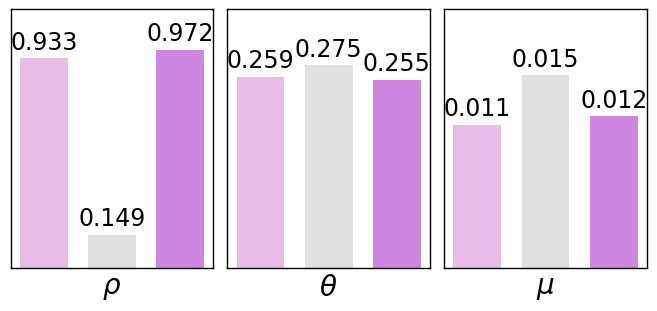

In [93]:
fig, axes = plt.subplots(1,3,layout='constrained', figsize=(6.5, 3))

params = [oracle_rho, single_rho, multi_rho]
rects = axes[0].bar(np.arange(3), params, color=colors, width=0.7, alpha=.7)
axes[0].bar_label(rects, padding=3, labels=[f"{p:.3f}" for p in params])
axes[0].set_yticks([])
axes[0].set_ylim(0, 1.15)
axes[0].set_xticks([0,1,2], ["", r"$\rho$", ""], fontsize=20)

params = [oracle_theta, single_theta, multi_theta+.04]
rects = axes[1].bar(np.arange(3), params, color=colors, width=0.7, alpha=.7)
axes[1].bar_label(rects, padding=3, labels=[f"{p:.3f}" for p in params])
axes[1].set_yticks([])
axes[1].set_ylim(0, 0.35)
axes[1].set_xticks([0,1,2], ["", r"$\theta$", ""], fontsize=20)

params = [oracle_mu, single_mu, multi_mu/32]
rects = axes[2].bar(np.arange(3), params, color=colors, width=0.7, alpha=.7)
axes[2].bar_label(rects, padding=3, labels=[f"{p:.3f}" for p in params])
axes[2].set_yticks([])
axes[2].set_ylim(0, 0.02)
axes[2].set_xticks([0,1,2], ["", r"$\mu$", ""], fontsize=20)
plt.show()

In [282]:
%matplotlib inline
plt.rc("figure", dpi=200)
SMALL_SIZE = 5
BIGGER_SIZE = 5
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=.3)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=BIGGER_SIZE)
plt.rc('figure', titlesize=1)
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['ytick.minor.size'] = 2

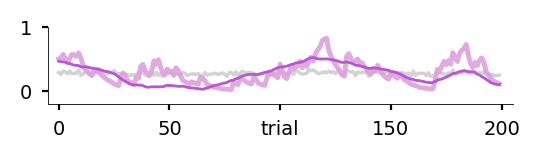

In [298]:
fig, ax = plt.subplots(1,1,figsize=(3, .5))
ax.plot(single_pred[:200], color="lightgray", linewidth=1.25, label=f"single-session ()")
ax.plot(oracle_pred[:200], color="plum", linewidth=1.75, alpha=.9, label="oracle")
ax.plot(multi_pred[:200]+0.7, color="mediumorchid", linewidth=1., label="multi-session")
ax.set_xlim(-5, 205)
ax.set_ylim(-0.2, 0.65)
ax.set_yticks([0, 1], [0, 1], fontsize=7)
ax.set_xticks([0, 50, 100, 150, 200], [0, 50, "trial", 150, 200],fontsize=7)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.legend(bbox_to_anchor=(1, 1.3), ncol=3, frameon=False, fontsize=10)
# plt.savefig("./plots/ssm_traces.png", dpi=200)

In [267]:
from sklearn.metrics import roc_auc_score, r2_score

In [268]:
print(r2_score(test_ys[:200], single_pred[:200]))
print(r2_score(test_ys[:200], oracle_pred[:200]))
print(r2_score(test_ys[:200], multi_pred[:200]+0.7))

0.07156361550044832
0.9995325608270469
0.30097316570054067
